# Vector Addition

In [1]:
import torch
import triton
import triton.language as tl

## L1

In [2]:
@triton.jit
def add_kernel(x_ptr, y_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    tl.store(output_ptr + offsets, output, mask=mask)


def add(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta["BLOCK_SIZE"]),)
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    return output


torch.manual_seed(42)
size = 98432
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise ValueError()
x = torch.rand(size, device=device)
y = torch.rand(size, device=device)
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(
    f"The maximum difference between torch and triton is {torch.max(torch.abs(output_torch - output_triton))}"
)

tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
The maximum difference between torch and triton is 0.0


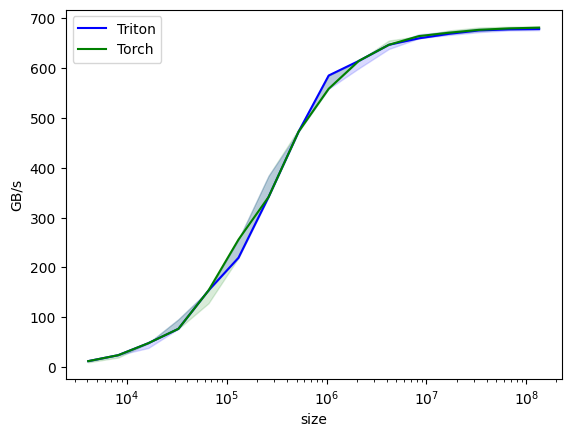

vector-add-performance:
           size      Triton       Torch
0        4096.0   12.000000   12.000000
1        8192.0   24.000000   24.000000
2       16384.0   48.000000   48.000000
3       32768.0   76.800002   76.800002
4       65536.0  153.600004  153.600004
5      131072.0  219.428568  255.999991
6      262144.0  341.333321  341.333321
7      524288.0  472.615390  472.615390
8     1048576.0  585.142862  558.545450
9     2097152.0  614.400016  614.400016
10    4194304.0  646.736871  646.736871
11    8388608.0  659.758391  664.216187
12   16777216.0  668.734699  671.017088
13   33554432.0  675.628857  676.791738
14   67108864.0  677.666529  679.716530
15  134217728.0  678.397218  681.188427


In [3]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],
        x_vals=[2 ** i for i in range(12, 28, 1)],
        x_log=True,
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="GB/s",
        plot_name="vector-add-performance",
        args={},
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device=device, dtype=torch.float32)
    y = torch.rand(size, device=device, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: add(x, y), quantiles=quantiles
        )
    gbps = lambda ms: (12 * size / ms) * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)

## L2

In [37]:
@triton.jit
def add_kernel(x_ptr, y_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    tl.store(output_ptr + offsets, output, mask=mask)


def add(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda

    n_elements = output.numel()

    grid = lambda meta: (triton.cdiv(n_elements, meta["BLOCK_SIZE"]),)
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    return output


torch.manual_seed(42)
size = 98432
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise ValueError()
x = torch.rand(size, device=device)
y = torch.rand(size, device=device)
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(
    f"The maximum difference between torch and triton is {torch.max(torch.abs(output_torch - output_triton))}"
)

tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
The maximum difference between torch and triton is 0.0


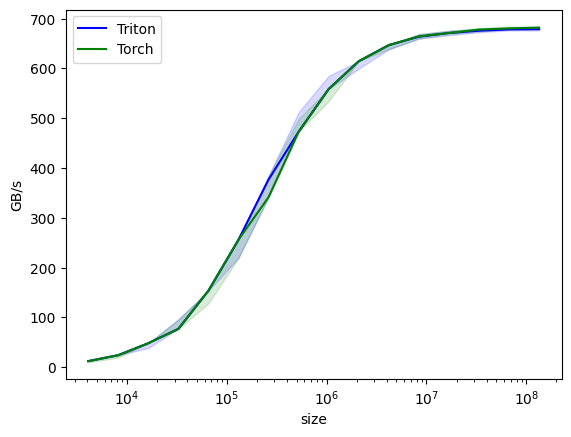

vector-add-performance:
           size      Triton       Torch
0        4096.0   12.000000   12.000000
1        8192.0   24.000000   24.000000
2       16384.0   48.000000   48.000000
3       32768.0   76.800002   76.800002
4       65536.0  153.600004  153.600004
5      131072.0  255.999991  255.999991
6      262144.0  376.643666  341.333321
7      524288.0  472.615390  472.615390
8     1048576.0  558.545450  558.545450
9     2097152.0  614.400016  614.400016
10    4194304.0  646.736871  646.736871
11    8388608.0  663.585713  664.216187
12   16777216.0  671.017088  671.017088
13   33554432.0  675.628857  677.958629
14   67108864.0  678.250981  680.304525
15  134217728.0  678.690016  681.778903


In [49]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],
        x_vals=[2 ** i for i in range(12, 28, 1)],
        x_log=True,
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="GB/s",
        plot_name="vector-add-performance",
        args={},
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device=device, dtype=torch.float32)
    y = torch.rand(size, device=device, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: add(x, y), quantiles=quantiles
        )

    gbps = lambda ms: (12 * size / ms) * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)

## L2.1

In [54]:
@triton.jit
def add_kernel(x_ptr, y_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    tl.store(output_ptr + offsets, output, mask=mask)


def add(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda

    n_elements = x.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta["BLOCK_SIZE"]),)
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    return output


torch.manual_seed(42)
size = 98432
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise ValueError()
x = torch.rand(size, device=device)
y = torch.rand(size, device=device)
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(
    f"The maximum difference between torch and triton is {torch.max(torch.abs(output_torch - output_triton))}"
)

tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
The maximum difference between torch and triton is 0.0


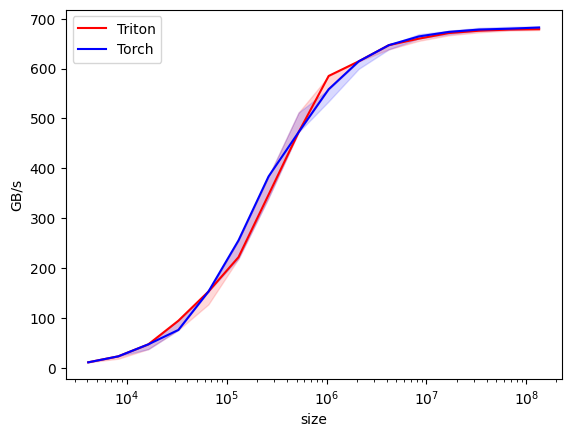

vector-add-performance:
           size      Triton       Torch
0        4096.0   12.000000   12.000000
1        8192.0   24.000000   24.000000
2       16384.0   48.000000   48.000000
3       32768.0   95.255819   76.800002
4       65536.0  153.600004  153.600004
5      131072.0  222.407245  255.999991
6      262144.0  347.363956  384.000001
7      524288.0  472.615390  472.615390
8     1048576.0  585.142862  558.545450
9     2097152.0  614.400016  614.400016
10    4194304.0  646.736871  646.736871
11    8388608.0  659.758391  664.216187
12   16777216.0  671.017088  673.315042
13   33554432.0  675.628857  677.958629
14   67108864.0  677.958629  679.716530
15  134217728.0  678.690016  682.074559


In [60]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],
        x_vals=[2 ** x for x in range(12, 28, 1)],
        x_log=True,
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("red", "-"), ("blue", "-")],
        ylabel="GB/s",
        plot_name="vector-add-performance",
        args={},
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device=device, dtype=torch.float32)
    y = torch.rand(size, device=device, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: add(x, y), quantiles=quantiles
        )

    gbps = lambda ms: 12 * (size / ms) * 1e-6

    return gbps(ms), gbps(max_ms), gbps(min_ms)


benchmark.run(print_data=True, show_plots=True)

## L2.2

In [67]:
@triton.jit
def add_kernel(x_ptr, y_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)

    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y

    tl.store(output_ptr + offsets, output, mask=mask)


def add(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)

    n_elements = x.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta["BLOCK_SIZE"]),)

    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    return output


torch.manual_seed(42)
size = 98432
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise ValueError()
x = torch.rand(size, device=device)
y = torch.rand(size, device=device)
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(
    f"The maximum difference between torch and triton is {torch.max(torch.abs(output_torch - output_triton))}"
)

tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
The maximum difference between torch and triton is 0.0


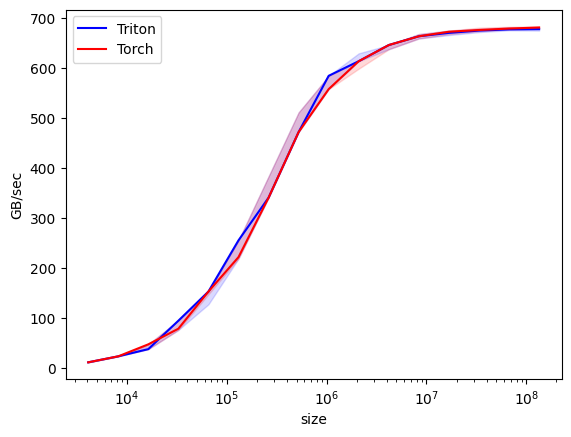

vector-add-performance:
           size      Triton       Torch
0        4096.0   12.000000   12.000000
1        8192.0   24.000000   24.000000
2       16384.0   38.400001   48.000000
3       32768.0   95.255819   79.277419
4       65536.0  153.600004  153.600004
5      131072.0  255.999991  222.407245
6      262144.0  341.333321  341.333321
7      524288.0  472.615390  472.615390
8     1048576.0  585.142862  558.545450
9     2097152.0  614.400016  614.400016
10    4194304.0  646.736871  646.736871
11    8388608.0  664.216187  664.216187
12   16777216.0  671.017088  673.315042
13   33554432.0  675.628857  676.791738
14   67108864.0  677.958629  679.716530
15  134217728.0  678.543585  681.778903


In [71]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],
        x_vals=[2 ** x for x in range(12, 28, 1)],
        x_log=True,
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("red", "-")],
        ylabel="GB/sec",
        plot_name="vector-add-performance",
        args={},
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device=device, dtype=torch.float32)
    y = torch.rand(size, device=device, dtype=torch.float32)

    quantiles = [0.5, 0.2, 0.8]

    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: add(x, y), quantiles=quantiles
        )
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)

    gbps = lambda ms: 12 * (size / ms) * 1e-6
    return gbps(ms), gbps(min_ms), gbps(max_ms)


benchmark.run(show_plots=True, print_data=True)

## L2.3

In [74]:
@triton.jit
def add_kernel(x_ptr, y_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y

    tl.store(output_ptr + offsets, output, mask=mask)


def add(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    n_elements = x.numel()

    grid = lambda meta: (triton.cdiv(n_elements, meta["BLOCK_SIZE"]),)

    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    return output


torch.manual_seed(42)
size = 98432
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise ValueError()
x = torch.rand(size, device=device)
y = torch.rand(size, device=device)
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(
    f"The maximum difference between torch and triton is {torch.max(torch.abs(output_torch - output_triton))}"
)

tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
The maximum difference between torch and triton is 0.0


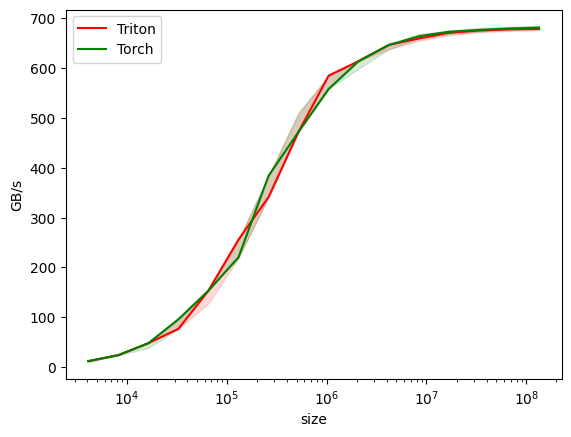

vector-addition-plot:
           size      Triton       Torch
0        4096.0   12.000000   12.000000
1        8192.0   24.000000   24.000000
2       16384.0   48.000000   48.000000
3       32768.0   76.800002   96.000000
4       65536.0  153.600004  153.600004
5      131072.0  255.999991  220.412561
6      262144.0  341.333321  384.000001
7      524288.0  472.615390  472.615390
8     1048576.0  585.142862  558.545450
9     2097152.0  614.400016  614.400016
10    4194304.0  646.736871  646.736871
11    8388608.0  659.758391  664.216187
12   16777216.0  671.017088  673.315042
13   33554432.0  675.628857  676.791738
14   67108864.0  677.958629  679.716530
15  134217728.0  678.690016  681.778903


In [77]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],
        x_vals=[2 ** x for x in range(12, 28, 1)],
        x_log=True,
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("red", "-"), ("green", "-")],
        ylabel="GB/s",
        plot_name="vector-addition-plot",
        args={},
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device=device, dtype=torch.float32)
    y = torch.rand(size, device=device, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]

    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: add(x, y), quantiles=quantiles
        )
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)

    gbps = lambda ms: 12 * (size / ms) * 1e-6
    return gbps(ms), gbps(min_ms), gbps(max_ms)


benchmark.run(show_plots=True, print_data=True)

## L2.8

In [2]:
@triton.jit
def add_kernel(x_ptr, y_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y

    tl.store(output_ptr + offsets, output, mask=mask)


def add(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    n_elements = x.numel()

    grid = lambda meta: (triton.cdiv(n_elements, meta["BLOCK_SIZE"]),)
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)

    return output


torch.manual_seed(42)
size = 98432
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise ValueError()
x = torch.rand(size, device=device)
y = torch.rand(size, device=device)
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(
    f"The maximum difference between torch and triton is {torch.max(torch.abs(output_torch - output_triton))}"
)

tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
The maximum difference between torch and triton is 0.0


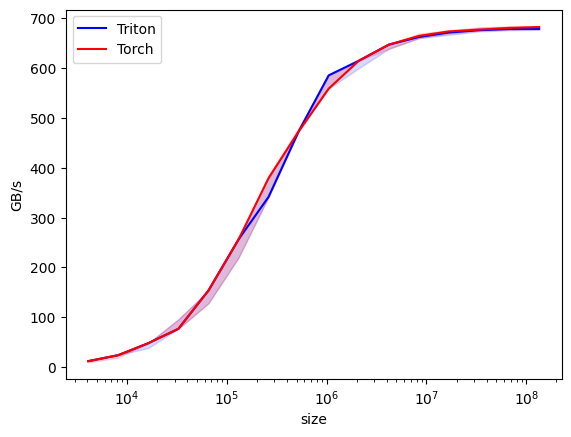

vector-addition-plot:
           size      Triton       Torch
0        4096.0   12.000000   12.000000
1        8192.0   24.000000   24.000000
2       16384.0   48.000000   48.000000
3       32768.0   76.800002   76.800002
4       65536.0  153.600004  153.600004
5      131072.0  255.999991  255.999991
6      262144.0  341.333321  378.820814
7      524288.0  472.615390  472.615390
8     1048576.0  585.142862  558.545450
9     2097152.0  614.400016  614.400016
10    4194304.0  646.736871  646.736871
11    8388608.0  661.979817  664.216187
12   16777216.0  671.017088  673.315042
13   33554432.0  675.628857  676.791738
14   67108864.0  677.958629  680.304525
15  134217728.0  678.104808  682.074559


In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],
        x_vals=[2 ** x for x in range(12, 28, 1)],
        x_log=True,
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("red", "-")],
        ylabel="GB/s",
        plot_name="vector-addition-plot",
        args={},
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device=device, dtype=torch.float32)
    y = torch.rand(size, device=device, dtype=torch.float32)

    quantiles = [0.5, 0.2, 0.8]

    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: add(x, y), quantiles=quantiles
        )
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)

    gbps = lambda ms: 12 * (size / ms) * 1e-6
    return gbps(ms), gbps(min_ms), gbps(max_ms)


benchmark.run(show_plots=True, print_data=True)

## L3

In [12]:
@triton.jit
def add_kernel(x_ptr, y_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y

    tl.store(output_ptr + offsets, output, mask=mask)


def add(x: torch.Tensor, y: torch.Tensor):
    output = torch.empty_like(x)
    n_elements = x.numel()

    grid = lambda meta: (triton.cdiv(n_elements, meta["BLOCK_SIZE"]),)
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)

    return output


torch.manual_seed(42)
size = 98432
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise ValueError()
x = torch.rand(size, device=device)
y = torch.rand(size, device=device)
output_torch = x + y
output_triton = add(x, y)
print(output_torch)
print(output_triton)
print(
    f"The maximum difference between torch and triton is {torch.max(torch.abs(output_torch - output_triton))}"
)

tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
tensor([1.6007, 0.1390, 0.9605,  ..., 0.9873, 0.4830, 0.5993], device='cuda:0')
The maximum difference between torch and triton is 0.0


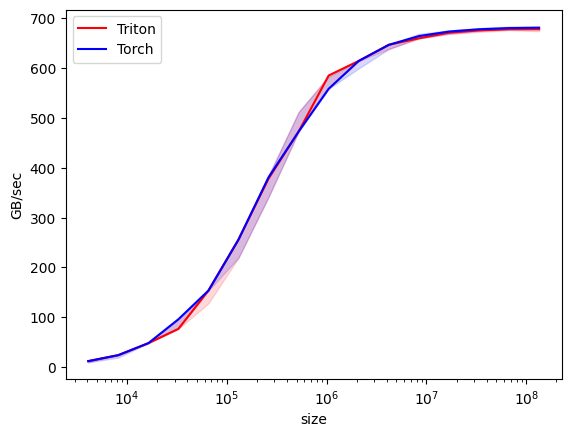

vector-add-plot:
           size      Triton       Torch
0        4096.0   12.000000   12.000000
1        8192.0   24.000000   24.000000
2       16384.0   48.000000   48.000000
3       32768.0   76.800002   96.000000
4       65536.0  153.600004  153.600004
5      131072.0  255.999991  255.999991
6      262144.0  378.092307  381.023277
7      524288.0  472.615390  472.615390
8     1048576.0  585.142862  558.545450
9     2097152.0  614.400016  614.400016
10    4194304.0  646.736871  646.736871
11    8388608.0  659.758391  664.216187
12   16777216.0  671.017088  673.315042
13   33554432.0  675.628857  677.958629
14   67108864.0  677.958629  680.304525
15  134217728.0  677.958629  681.054717


In [13]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],
        x_vals=[2 ** x for x in range(12, 28, 1)],
        x_log=True,
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("red", "-"), ("blue", "-")],
        ylabel="GB/sec",
        plot_name="vector-add-plot",
        args={},
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device=device, dtype=torch.float32)
    y = torch.rand(size, device=device, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]

    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: add(x, y), quantiles=quantiles
        )
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)

    gbps = lambda ms: 12 * (size / ms) * 1e-6
    return gbps(ms), gbps(min_ms), gbps(max_ms)


benchmark.run(show_plots=True, print_data=True)